In [ ]:
#!pip install -q kaggle

In [ ]:
# =========================================
# 0- Mount Google Drive
# =========================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================================
# 1️- Initial Setup, Kaggle Connection, and Data Download
# =========================================
import os
import shutil

KAGGLE_CREDENTIALS_PATH = "/content/drive/MyDrive/kaggle/kaggle.json"
KAGGLE_DATASET_ID = "gti-upm/leapgestrecog"

DOWNLOAD_DIR = "/content/leap_gesture_data"
DATA_ROOT_PATH_RAW_BASE = os.path.join(DOWNLOAD_DIR, 'leapgestrecog')
FIXED_ROOT_PATH = '/content/leap_gesture_data/fixed_data'
MODEL_SAVE_PATH = "/content/drive/MyDrive/Kaggle_Gesture_Dataset/best_inceptionv1_leap_model.h5"

# Clean previous data if exists
for path in [DOWNLOAD_DIR, FIXED_ROOT_PATH]:
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Removed previous directory: {path}")


if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

shutil.copy(KAGGLE_CREDENTIALS_PATH, "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

os.makedirs(DOWNLOAD_DIR)
print("Downloading dataset...")
!kaggle datasets download -d {KAGGLE_DATASET_ID} -p {DOWNLOAD_DIR} --unzip
print(f"Dataset downloaded and unzipped to {DOWNLOAD_DIR}")


Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 98% 2.08G/2.13G [00:56<00:11, 5.16MB/s]
100% 2.13G/2.13G [00:56<00:00, 40.8MB/s]
Dataset downloaded and unzipped to /content/leap_gesture_data


In [ ]:
# =========================================
# 2️- Data Reorganization
# =========================================
print("\n--- Starting data reorganization ---")

DATA_ROOT_PATH_FINAL = os.path.join(DATA_ROOT_PATH_RAW_BASE, 'leapGestRecog')
if not os.path.exists(DATA_ROOT_PATH_FINAL):
    print("CRITICAL: Final raw data path not found, using raw base")
    DATA_ROOT_PATH_FINAL = DATA_ROOT_PATH_RAW_BASE
else:
    print(f"Using confirmed raw data path: {DATA_ROOT_PATH_FINAL}")

os.makedirs(FIXED_ROOT_PATH, exist_ok=True)

files_moved_count = 0
for subject_folder in os.listdir(DATA_ROOT_PATH_FINAL):
    subject_path = os.path.join(DATA_ROOT_PATH_FINAL, subject_folder)
    if os.path.isdir(subject_path) and subject_folder.isdigit():
        for gesture_folder in os.listdir(subject_path):
            source_gesture_path = os.path.join(subject_path, gesture_folder)
            if os.path.isdir(source_gesture_path):
                destination_path = os.path.join(FIXED_ROOT_PATH, gesture_folder)
                os.makedirs(destination_path, exist_ok=True)
                for filename in os.listdir(source_gesture_path):
                    if filename.endswith('.png'):
                        shutil.move(
                            os.path.join(source_gesture_path, filename),
                            destination_path
                        )
                        files_moved_count += 1

print(f"Data reorganization complete. Total files moved: {files_moved_count}")

# Verify file count
total_files = !find {FIXED_ROOT_PATH} -type f -name "*.png" | wc -l
total_files_count = int(total_files[0].strip())
print(f"TOTAL FINAL PNG FILES FOUND: {total_files_count}")

if total_files_count < 20000:
    print("CRITICAL WARNING: Files are missing. Expected 20,000. Proceed with caution.")
else:
    print("SUCCESS: File count is correct (20,000 files expected).")


--- Starting data reorganization ---
Using confirmed raw data path: /content/leap_gesture_data/leapgestrecog/leapGestRecog
Data reorganization complete. Total files moved: 20000
TOTAL FINAL PNG FILES FOUND: 20000
SUCCESS: File count is correct (20,000 files expected).


In [ ]:
# ==============================
# STEP 3 — Imports
# ==============================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import googlenet, GoogLeNet_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Dataset Path
DATA_ROOT = FIXED_ROOT_PATH
print("Loading dataset from:", DATA_ROOT)

Using device: cuda
Loading dataset from: /content/leap_gesture_data/fixed_data


In [ ]:
# ==============================
# STEP 4 — Data Preprocessing & Augmentation
# ==============================
# Separate transforms: Augment only training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize first
    transforms.RandomHorizontalFlip(p=0.5),  # Mirror images
    transforms.RandomRotation(degrees=15),  # Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Lighting/contrast shifts
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([  # No augmentation for test
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset with train_transform (but we'll override for test split)
full_dataset = datasets.ImageFolder(DATA_ROOT, transform=train_transform)  # ImageFolder read the dataset as rgb by default ,grayscale images channel repeated 3 times
num_classes = len(full_dataset.classes)

# For splitting: Create custom subsets with appropriate transforms
from torch.utils.data import Subset
import numpy as np

# Get indices for split
indices = np.arange(len(full_dataset))
np.random.seed(42)  # Add seed for reproducible splits
np.random.shuffle(indices)
test_size = int(0.2 * len(full_dataset)) # test set is 20%
test_indices = indices[:test_size]
train_indices = indices[test_size:]

# Train dataset with augmentation
train_dataset = Subset(full_dataset, train_indices)  # Uses train_transform

# Test dataset
full_test_dataset = datasets.ImageFolder(DATA_ROOT, transform=test_transform)
test_dataset = Subset(full_test_dataset, test_indices)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 16000, Test size: 4000


In [ ]:
# ==============================
# STEP 5 — Load Pretrained Inception V1 (GoogLeNet)
# ==============================
weights = GoogLeNet_Weights.IMAGENET1K_V1
model = googlenet(weights=weights)

# Freeze all layers (ONLY TRANSFER LEARNING)
for param in model.parameters():
    param.requires_grad = False

# Replace final FC Layer (Fully Connected) for the dataset
model.fc = nn.Linear(1024, num_classes)

model = model.to(device)

# Loss + Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0008)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 124MB/s]


In [ ]:
# ==============================
# STEP 6.0 — Initialize History Containers
# ==============================
train_losses = []
train_accuracies = []
val_accuracies = []


In [ ]:
# ==============================
# STEP 6.1 — Accuracy Function
# ==============================
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


In [ ]:
# ==============================
# STEP 6 — Training Loop
# ==============================
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Training accuracy
    train_acc = calculate_accuracy(model, train_loader)
    train_accuracies.append(train_acc)

    # Validation accuracy
    val_acc = calculate_accuracy(model, test_loader)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Loss: {epoch_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

print("Training finished.")


Epoch 1/10 | Loss: 1.0848 | Train Acc: 0.8882 | Val Acc: 0.9137
Epoch 2/10 | Loss: 0.5236 | Train Acc: 0.9254 | Val Acc: 0.9445
Epoch 3/10 | Loss: 0.4032 | Train Acc: 0.9423 | Val Acc: 0.9613
Epoch 4/10 | Loss: 0.3402 | Train Acc: 0.9503 | Val Acc: 0.9735
Epoch 5/10 | Loss: 0.3013 | Train Acc: 0.9545 | Val Acc: 0.9765
Epoch 6/10 | Loss: 0.2804 | Train Acc: 0.9603 | Val Acc: 0.9798
Epoch 7/10 | Loss: 0.2704 | Train Acc: 0.9584 | Val Acc: 0.9860
Epoch 8/10 | Loss: 0.2472 | Train Acc: 0.9637 | Val Acc: 0.9860
Epoch 9/10 | Loss: 0.2380 | Train Acc: 0.9623 | Val Acc: 0.9840
Epoch 10/10 | Loss: 0.2315 | Train Acc: 0.9671 | Val Acc: 0.9860
Training finished.


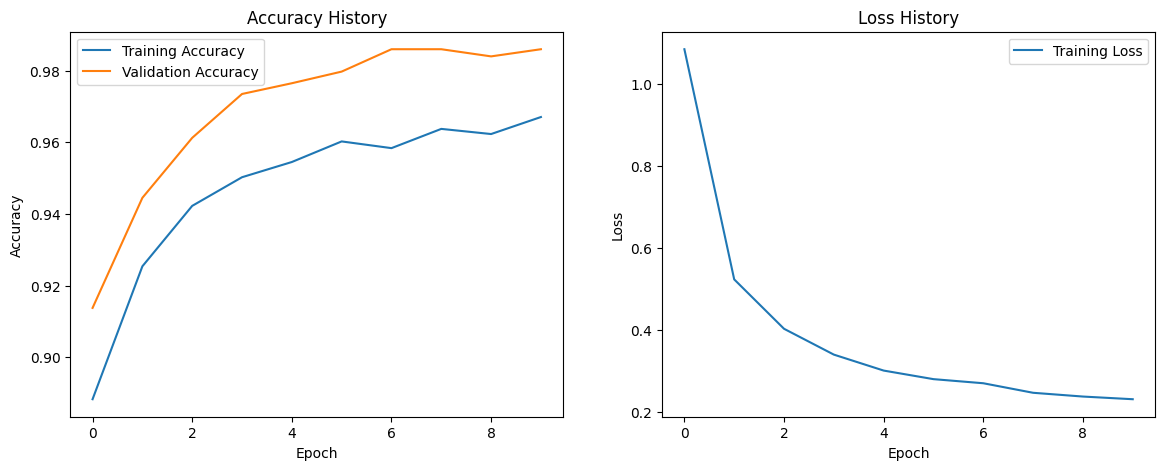

In [ ]:
# ==============================
# STEP 6.3 — Plot Training History
# ==============================
import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy History")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()

plt.show()


In [ ]:
# ==============================
# STEP 7 — Evaluation
# ==============================
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (pred == labels).sum().item()

    return 100 * correct / total

test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 98.60%


In [ ]:

# ------------------------------
# STEP 7.1 — Collect Predictions & Probabilities
# ------------------------------
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Convert outputs to probabilities
        probs = torch.softmax(outputs, dim=1)

        # Get predicted class
        _, preds = torch.max(probs, 1)

        # Store results
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("Predictions collected successfully.")


Predictions collected successfully.


In [ ]:
# ------------------------------
# STEP 7.2 — Precision, Recall, F1-score
# ------------------------------
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    target_names=full_dataset.classes
))



               precision    recall  f1-score   support

      01_palm       0.99      0.99      0.99       352
         02_l       0.99      0.98      0.98       429
      03_fist       1.00      0.98      0.99       413
04_fist_moved       0.96      0.99      0.97       413
     05_thumb       1.00      1.00      1.00       412
     06_index       0.98      0.96      0.97       397
        07_ok       0.99      1.00      0.99       413
08_palm_moved       1.00      0.99      1.00       387
         09_c       0.98      0.99      0.99       402
      10_down       0.97      0.98      0.98       382

     accuracy                           0.99      4000
    macro avg       0.99      0.99      0.99      4000
 weighted avg       0.99      0.99      0.99      4000



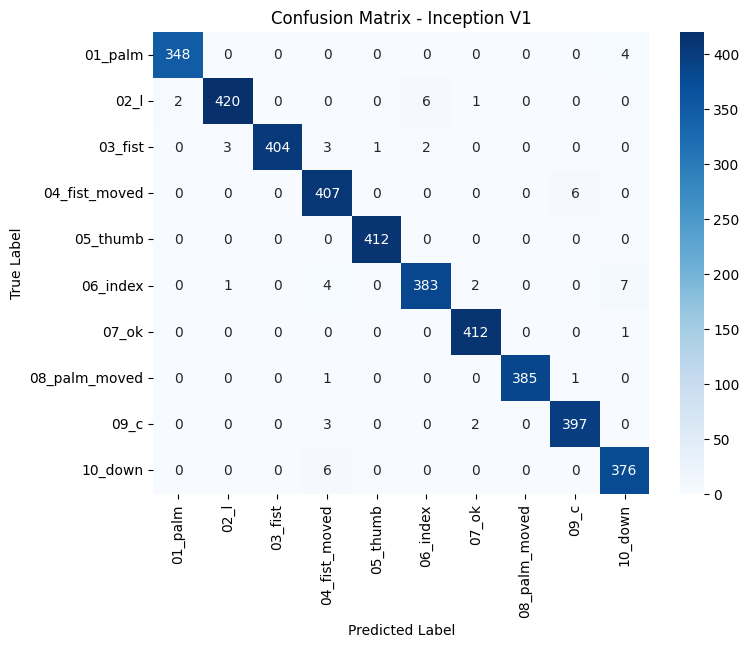

In [ ]:

# ------------------------------
# STEP 7.3 — Confusion Matrix Visualization
# ------------------------------
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Inception V1")
plt.show()


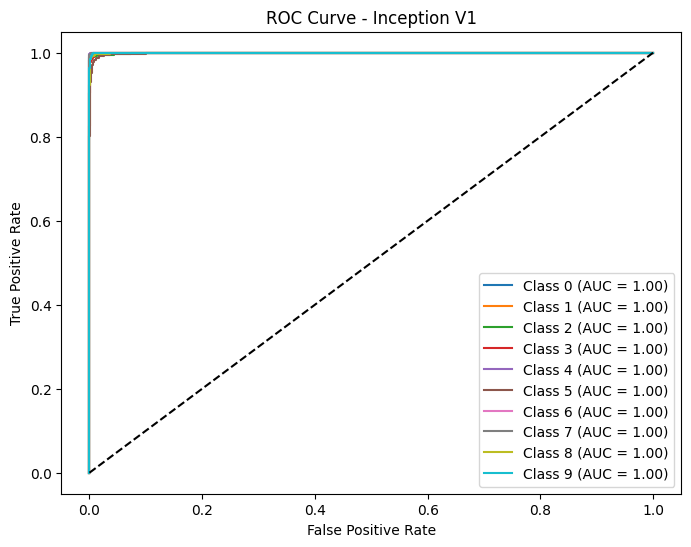

In [ ]:

# ------------------------------
# STEP 7.4 — ROC Curve & AUC (Multi-Class)
# ------------------------------
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = len(full_dataset.classes)

# Binarize labels for multi-class ROC
labels_bin = label_binarize(all_labels, classes=range(num_classes))

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Random classifier reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Inception V1")
plt.legend()
plt.show()
